100%|██████████| 10000/10000 [00:02<00:00, 3440.73it/s]


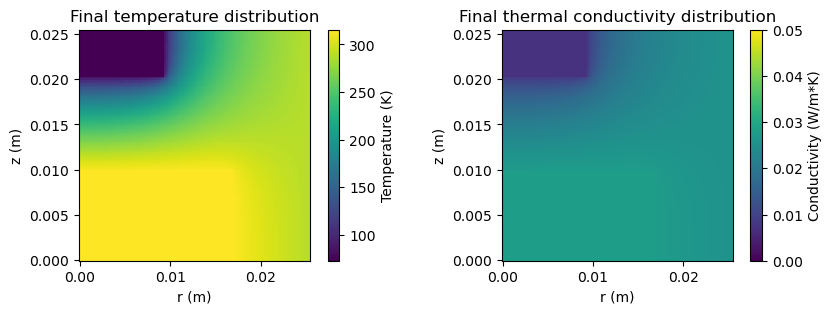

In [1]:

import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from tqdm import tqdm # optional; a nice way to show a progress bar for long loops

# for a really useful reference see https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a

## define physical constants and simulation parameters ##

# thermal conductivities in W/m*K
kcopper = 385
ksteel = 50.2
kairpower = 0.918
kairconstant = 0.00014
def kair(T):
    # this is a rough approximation of the thermal conductivity of air as a function of temperature
    # in the range we care about. See H20/Theory/Old Theory/Graph8.png. We should double check this. 
    return kairconstant * T**kairpower

# temperatures in K
bucket_temp = 73 # top bucket (liquid nitrogen)
plate_temp = 315.5 # bottom plate (hot plate)
boundary_temp = 289 # boundary temperature (room temperature)

# geometry of the system in inches
bucket_radius = .367 # radius of the top bucket
plate_radius = .665 # radius of the bottom plate
plate_height = 1 - 0.6102362 # height of the bottom plate
separation_height = 0.6102362 - 0.1969 # separation between the top bucket and the bottom plate
simulation_radius = 1 # radius of the simulation
simulation_height = 1 # height of the simulation

# define the number of grid points
Nr = 128 # number of grid points in the radial direction
Nz = 128 # number of grid points in the axial direction


## no need to change anything below this line ##

# convert geometry to meters
# you could also just define these in meters to begin with
bucket_radius *= 0.0254
plate_radius *= 0.0254
plate_height *= 0.0254
separation_height *= 0.0254
simulation_radius *= 0.0254
simulation_height *= 0.0254

# compute the grid spacing
dr = simulation_radius / Nr # grid spacing in the radial direction
dz = simulation_height / Nz # grid spacing in the axial direction

# set up the grid
r = np.linspace(0, simulation_radius, Nr)
z = np.linspace(0, simulation_height, Nz)
Z, R = np.meshgrid(z, r) 
Zpix, Rpix = np.meshgrid(np.arange(Nz), np.arange(Nr))
# meshgrid returns two 2D arrays, R and Z, that contain the r and z values at each point in the grid


# set up the temperature and thermal conductivity arrays
T = np.zeros((Nr, Nz)) # temperature
k = np.zeros((Nr, Nz)) # thermal conductivity

# set up "masks", which are arrays that are 1 where a condition is true and 0 where it is false
# these masks will be used to apply boundary conditions and to define the regions of the system
# replaces the "thermal conductivity" and "boundary_condition" functions from the old code
plate_mask = np.logical_and(R < plate_radius, Z < plate_height) 
bucket_mask = np.logical_and(R < bucket_radius, Z > separation_height + plate_height)
air_mask = np.logical_not(np.logical_or(plate_mask, bucket_mask))
boundary_mask = R == simulation_radius


# set up the initial temperature distribution
T[:, :] = boundary_temp

# set up the initial thermal conductivity
k[plate_mask] = kcopper
k[bucket_mask] = ksteel
k[air_mask] = kair(T[air_mask])

# initialize various variables
dradd = np.zeros((Nr, Nz))
drsub = np.zeros((Nr, Nz))
dzadd = np.zeros((Nr, Nz))
dzsub = np.zeros((Nr, Nz))

# define the number of iterations to perform
iterations = 10000 # number of iterations to perform

# start the simulation 
for t in tqdm(range(iterations)):

    # apply boundary conditions
    T[boundary_mask] = boundary_temp
    T[plate_mask] = plate_temp
    T[bucket_mask] = bucket_temp
    
    # compute thermal conductivity
    k = kair(T)

    # compute terms in the bulk
    dradd = k / (dr**2)
    dzadd = k / (dz**2)
    drsub[1:-1, :] = k[1:-1, :] / (2 * dr * R[1:-1, :]) + (k[2:, :] - k[:-2, :]) / (2 * dr)**2
    dzsub[:, 1:-1] = (k[:, 2:] - k[:, :-2]) / (2 * dz)**2

    # compute terms at the boundaries
    drsub[0, :] = k[0, :] / (dr**2)
    drsub[-1, :] = - k[-1, :] / (dr**2)
    dzsub[:, 0] = k[:, 0] / (dz**2)
    dzsub[:, -1] = - k[:, -1] / (dz**2)

    # compute update
    T = (np.roll(T, -1, 0) * (dradd + drsub) + np.roll(T, 1, 0) * (dradd - drsub)
         + np.roll(T, -1, 1) * (dzadd + dzsub) + np.roll(T, 1, 1) * (dzadd - dzsub))
    T = T / (2 * k * (1/dr**2 + 1/dz**2))
    

# # apply boundary conditions
T[boundary_mask] = boundary_temp
T[plate_mask] = plate_temp
T[bucket_mask] = bucket_temp

# plot the final temperature distribution
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1, aspect='equal')
plt.pcolormesh(r, z, np.transpose(T))#, vmin=bucket_temp, vmax=plate_temp)
plt.xlabel('r (m)')
plt.ylabel('z (m)')
plt.colorbar(label='Temperature (K)')
plt.title('Final temperature distribution') 
plt.subplot(1, 2, 2, aspect='equal')
plt.pcolormesh(r, z, np.transpose(k), vmin=0, vmax=0.05)
plt.xlabel('r (m)')
plt.ylabel('z (m)')
plt.colorbar(label='Conductivity (W/m*K)')
plt.title('Final thermal conductivity distribution') 
plt.show()


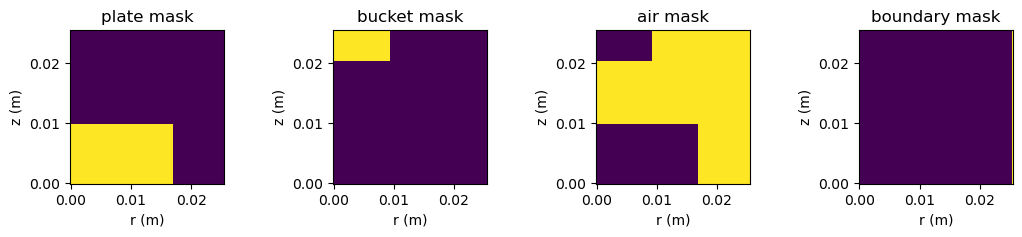

In [2]:
# check that our masks look right
plt.figure(figsize=(13, 2))
plt.subplot(1, 4, 1, aspect='equal')
plt.pcolormesh(r, z, np.transpose(plate_mask))
plt.title('plate mask')
plt.xlabel('r (m)')
plt.ylabel('z (m)')
plt.subplot(1, 4, 2, aspect='equal')
plt.pcolormesh(r, z, np.transpose(bucket_mask))
plt.title('bucket mask')
plt.xlabel('r (m)')
plt.ylabel('z (m)')
plt.subplot(1, 4, 3, aspect='equal')
plt.pcolormesh(r, z, np.transpose(air_mask))
plt.title('air mask')
plt.xlabel('r (m)')
plt.ylabel('z (m)')
plt.subplot(1, 4, 4, aspect='equal')
plt.pcolormesh(r, z, np.transpose(boundary_mask))
plt.title('boundary mask')
plt.xlabel('r (m)')
plt.ylabel('z (m)')
plt.show()


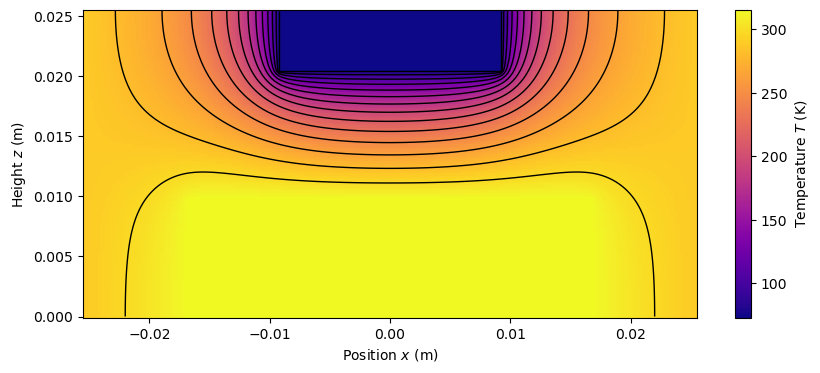

In [3]:
fullT = np.concatenate((np.flip(T[1:, :], 0), T), axis=0)
x = np.concatenate((-np.flip(r[1:], 0), r), axis=0)

plt.figure(figsize=(10,4))
cs = plt.pcolormesh(x, z, np.transpose(fullT), cmap='plasma', vmin=bucket_temp, vmax=plate_temp)

plt.colorbar(label='Temperature $T$ (K)', ticks = [100, 150, 200, 250, 300, 350])
plt.gca().set_aspect('equal')

cs2 = plt.contour(x, z, np.transpose(fullT), levels=np.linspace(bucket_temp, plate_temp, 15), colors='black',linewidths=1)


plt.xlabel('Position $x$ (m)')
plt.ylabel('Height $z$ (m)')
plt.show()


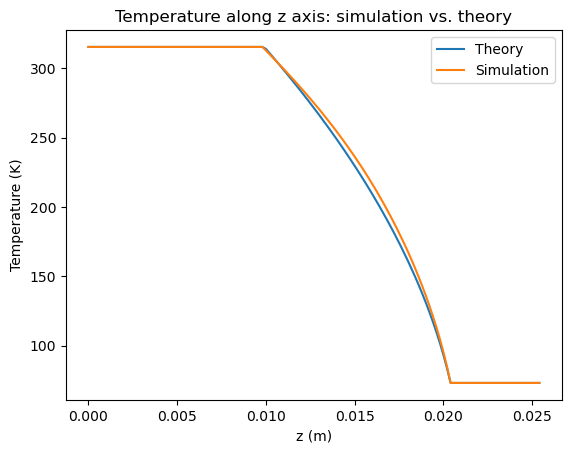

In [4]:
# compare temperature along z axis to theory 

B_theory = plate_temp**(1 + kairpower)
A_theory = (bucket_temp**(1 + kairpower) - B_theory) / separation_height
Tz_theory = np.zeros(Nz)
Tz_theory[z < plate_height] = plate_temp
Tz_theory[z > separation_height + plate_height] = bucket_temp
mask = np.logical_and(z >= plate_height, z <= separation_height + plate_height)
Tz_theory[mask] = (A_theory * (z[mask] - plate_height) + B_theory)**(1/(1 + kairpower))

plt.figure()
plt.plot(z, Tz_theory, label='Theory')
plt.plot(z, T[0, :], label='Simulation')
plt.xlabel('z (m)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Temperature along z axis: simulation vs. theory')
plt.show()

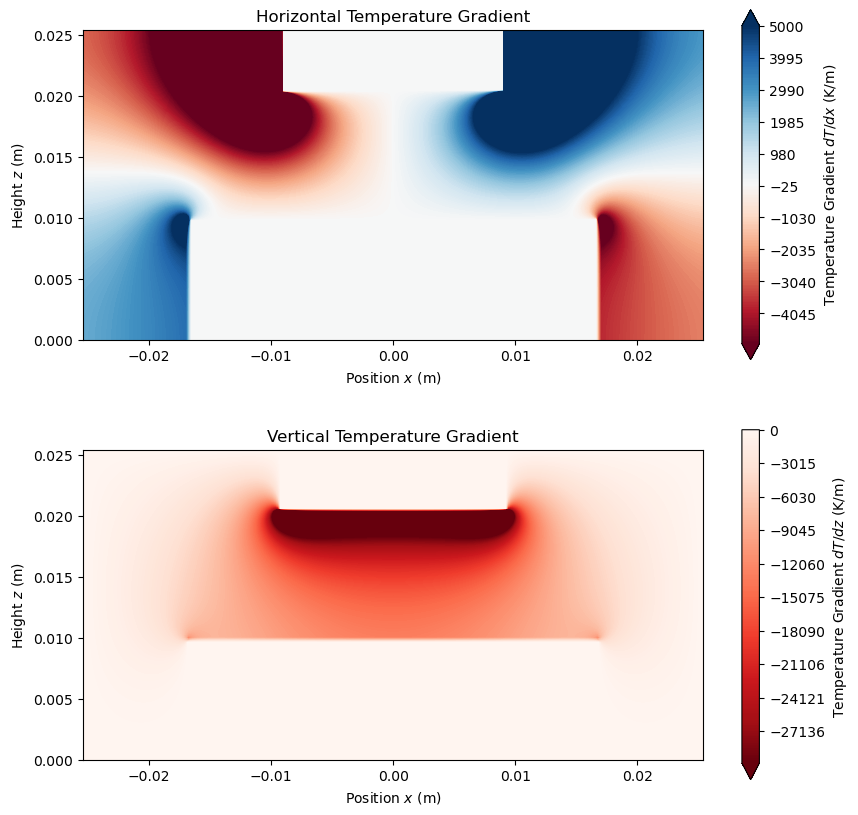

In [5]:
grad_x, grad_z = np.gradient(fullT, dr, dz)
xclims = 5e3
zclims = 3e4
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1, aspect='equal')
plt.contourf(x, z, np.transpose(grad_x), levels=np.linspace(-xclims, xclims, 200), cmap='RdBu', extend='both')
plt.colorbar(label='Temperature Gradient $dT/dx$ (K/m)')
plt.xlabel('Position $x$ (m)')
plt.ylabel('Height $z$ (m)')
plt.title('Horizontal Temperature Gradient')
plt.subplot(2, 1, 2, aspect='equal')
plt.contourf(x, z, np.transpose(grad_z), levels=np.linspace(-zclims, 0, 200), cmap='Reds_r', extend='min')
plt.colorbar(label='Temperature Gradient $dT/dz$ (K/m)')
plt.xlabel('Position $x$ (m)')
plt.ylabel('Height $z$ (m)')
plt.title('Vertical Temperature Gradient')
plt.show()


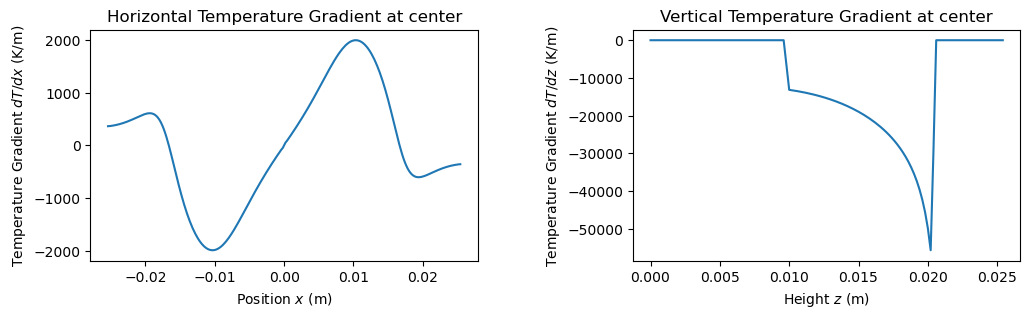

In [6]:
plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
plt.plot(x, grad_x[:, int(Nz/2)])
plt.xlabel('Position $x$ (m)')
plt.ylabel('Temperature Gradient $dT/dx$ (K/m)')
plt.title('Horizontal Temperature Gradient at center')
plt.subplot(1, 2, 2)
plt.plot(z, grad_z[int(Nr), :])
plt.xlabel('Height $z$ (m)')
plt.ylabel('Temperature Gradient $dT/dz$ (K/m)')
plt.title('Vertical Temperature Gradient at center')
plt.subplots_adjust(wspace=0.4)
plt.show()


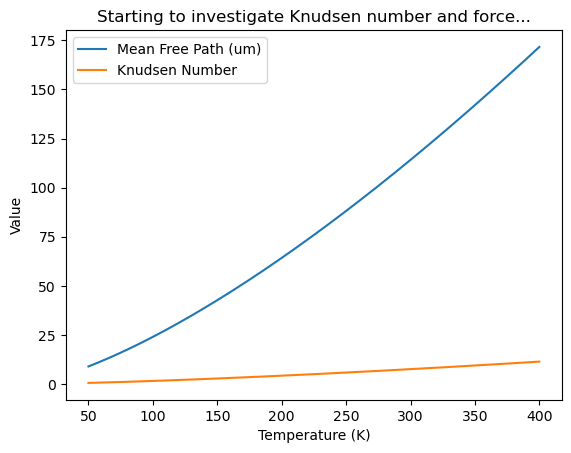

In [7]:
# Hi Otto - below here I'm not confident in the units and formulas.
# Here we are computing forces - this is all copied from /H2O/2016paper_APL/Code/thermophoreticForce.py

molecMassAir = 4.81e-26
boltzmannConstant = 1.38065e-23

def meanFreePath(airThermalConductivity, pressure, temp):
    # pressure in Torr, temp in K, airThermalConductivity in W/m*K
    # returns mean free path in meters
    return 4 * airThermalConductivity / (5 * pressure * 133.322) * np.sqrt(molecMassAir * temp / (2 * boltzmannConstant))
    
def knudsenNumber(meanFreePath, particleRadius):
    # meanFreePath and particleRadius in meters
    return meanFreePath / particleRadius

def f_T(knudsenNumber):
    # knudsenNumber is dimensionless
    # returns the thermophoretic force coefficient
    return (9 * knudsenNumber**3) / (1 + 4.4844 * knudsenNumber**2) / (1 + knudsenNumber)

def newf_T(knudsenNumber):
    ft = -.2906*knudsenNumber**2 + 1.354*knudsenNumber - .2706
    if (knudsenNumber < .35) or (knudsenNumber > 2):
        print("Warning: f_T inaccurate, switch from newf_T function.")
        return ft
    return ft

def thermophoreticForce(f_T, particleRadius, airThermalConductivity, temp, tempGradient):
    return -(f_T * particleRadius**2 * airThermalConductivity * 
             tempGradient / np.sqrt(2 * boltzmannConstant * temp / molecMassAir))


# Henry's attempt to use these functions
# are these values plausible? 

press = 1 # Torr
radius = 15e-6 # meters
tarr = np.linspace(50, 400, 200) # K
karr = kair(tarr) # W/m*K
meanFreePathArr = meanFreePath(karr, press, tarr) # m
knudsenNumberArr = knudsenNumber(meanFreePathArr, radius) # dimensionless
f_Tarr = f_T(knudsenNumberArr) # dimensionless

plt.figure()
plt.plot(tarr, 1e6 * meanFreePathArr, label='Mean Free Path (um)')
plt.plot(tarr, knudsenNumberArr, label='Knudsen Number')
plt.xlabel('Temperature (K)')
plt.ylabel('Value')
plt.legend()
plt.title('Starting to investigate Knudsen number and force...')
plt.show()

